# Look at debugging outputs

In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import pprint
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class args:
    pass

args.dout = 'exp/model:seq2seq_nl_baseline,name:full_3_epoch_20'

In [1]:
!ls -l exp/model:seq2seq_nl_baseline,name:full_3_epoch_20

total 457940
-rw-r--r-- 1 root root       403 Apr 10 06:45 best_seen.json
-rw-r--r-- 1 root root 153981998 Apr 10 06:45 best_seen.pth
-rw-r--r-- 1 root root       405 Apr 10 01:17 best_unseen.json
-rw-r--r-- 1 root root 153981998 Apr 10 01:17 best_unseen.pth
-rw-r--r-- 1 root root       894 Apr  9 18:23 config.json
-rw-r--r-- 1 root root   4845847 Apr 10 06:51 events.out.tfevents.1586456582.1f9a25fd06f3
-rw-r--r-- 1 root root 153981998 Apr 10 06:45 latest.pth
-rw-r--r-- 1 root root     24124 Apr 10 06:51 log.txt
-rw-r--r-- 1 root root    281777 Apr  9 19:06 valid_seen.debug_epoch_0.preds.json
-rw-r--r-- 1 root root    190935 Apr 10 06:01 valid_seen.debug_epoch_14.preds.json
-rw-r--r-- 1 root root    184246 Apr 10 06:45 valid_seen.debug_epoch_15.preds.json
-rw-r--r-- 1 root root    196765 Apr  9 19:50 valid_seen.debug_epoch_1.preds.json
-rw-r--r-- 1 root root    179390 Apr  9 21:21 valid_seen.debug_epoch_3.preds.json
-rw-r--r-- 1 root root    190116 Apr 10 01:17 valid_seen.debug_epoch_8

In [3]:
valid_seen_epoch_list = [0,1,3,8,14,15]
valid_unseen_epoch_list = [0,1,3,8]

# Examine Outputs across Epochs

- across epochs
- random selection
- rank by CE, BLEU

### SECTION 1: Select a random set of tasks to look at

#### Real Data

In [37]:
np.random.seed(42)

path = os.path.join(args.dout, 'valid_seen.debug_epoch_0.preds.json')
with open(path, 'r') as f:
    debug_valid_seen = json.load(f)
chosen_valid_seen_task_ids = np.random.choice(list(debug_valid_seen.keys()), size=10, replace=False)

path = os.path.join(args.dout, 'valid_unseen.debug_epoch_0.preds.json')
with open(path, 'r') as f:
    debug_valid_unseen = json.load(f)
chosen_valid_unseen_task_ids = np.random.choice(list(debug_valid_unseen.keys()), size=10, replace=False)

def find_num_high_level_goals(chosen_task_ids, debug_dat):
    '''number of high level goals (complexity) of these chosen tasks'''
    for t in chosen_task_ids:
        print (t, '\t\t\t', len(debug_dat[t]['action_high']))
    
print("\nRandomly Selected for Valid Seen: (task, number of planner subgoals)")
find_num_high_level_goals(chosen_valid_seen_task_ids, debug_valid_seen)
print("\nRandomly Selected for Valid Unseen: (task, number of planner subgoals)")
find_num_high_level_goals(chosen_valid_unseen_task_ids, debug_valid_unseen)


Randomly Selected for Valid Seen: (task, number of planner subgoals)
trial_T20190909_150916_682139_0 			 5
trial_T20190908_192636_561572_0 			 8
trial_T20190907_013001_399963_0 			 12
trial_T20190907_074712_870488_0 			 8
trial_T20190908_102840_789300_0 			 9
trial_T20190909_031040_889814_0 			 5
trial_T20190908_140701_251653_0 			 7
trial_T20190909_055649_717880_0 			 9
trial_T20190907_151802_277016_0 			 13
trial_T20190909_032318_169393_0 			 5

Randomly Selected for Valid Unseen: (task, number of planner subgoals)
trial_T20190909_123918_983775_0 			 13
trial_T20190909_123732_489327_0 			 11
trial_T20190906_191445_723170_0 			 5
trial_T20190907_020329_050110_0 			 7
trial_T20190907_170955_824797_0 			 5
trial_T20190909_210238_431966_0 			 5
trial_T20190906_224843_443882_0 			 13
trial_T20190906_214631_761426_0 			 5
trial_T20190907_074524_006355_0 			 5
trial_T20190908_114656_768805_0 			 7


In [4]:
chosen_valid_seen_task_ids = [
'trial_T20190909_150916_682139_0', 
'trial_T20190908_192636_561572_0', 
'trial_T20190907_013001_399963_0', 
'trial_T20190907_074712_870488_0', 
'trial_T20190908_102840_789300_0', 
'trial_T20190909_031040_889814_0', 
'trial_T20190908_140701_251653_0', 
'trial_T20190909_055649_717880_0', 
'trial_T20190907_151802_277016_0', 
'trial_T20190909_032318_169393_0'
]

chosen_valid_unseen_task_ids = [
'trial_T20190909_123918_983775_0',
'trial_T20190909_123732_489327_0',
'trial_T20190906_191445_723170_0',
'trial_T20190907_020329_050110_0',
'trial_T20190907_170955_824797_0',
'trial_T20190909_210238_431966_0',
'trial_T20190906_224843_443882_0',
'trial_T20190906_214631_761426_0',
'trial_T20190907_074524_006355_0',
'trial_T20190908_114656_768805_0'
]

In [5]:
def get_language_annotations(root):
    lang_goals = []
    lang_instrs = []
    path = os.path.join(root, 'pp', 'ann_%d.json' % 0)
    with open(path, 'r') as f:
        ex = json.load(f)
        for i in range(3):
            lang_goals.append(ex['turk_annotations']['anns'][i]['task_desc'])
            lang_instrs.append(ex['turk_annotations']['anns'][i]['high_descs'])
        action_low = [a['discrete_action']['action'] for a in ex['plan']['low_actions']]
        action_high = [a['discrete_action']['action'] for a in ex['plan']['high_pddl']]
    return lang_goals, lang_instrs, action_high, action_low  

def get_ref_instrs(root):
    flatten_isntr = lambda instr: [word.strip() for sent in instr for word in sent]
    ref_instrs = []
    for i in range(3):
        path = os.path.join(root, 'pp', 'ann_%d.json' % i)
        if os.path.exists(path):
            with open(path, 'r') as f:
                ex = json.load(f)
                ref_instrs.append(flatten_isntr(ex['ann']['instr']))
    return ref_instrs

def examine_sampled_tasks(sampled_task_ids, epoch_list, split):
    sampled_results = defaultdict(dict)

    for epoch in epoch_list:

        path = os.path.join(args.dout, '{}.debug_epoch_{}.preds.json'.format(split, epoch))
        with open(path, 'r') as f:
            debug_dat = json.load(f)

        for task_id in sampled_task_ids:
            if epoch == 0:
                root = debug_dat[task_id]['root']  # root location
                
                # get all language and action annotations
                sampled_results[task_id]['lang_goal'], sampled_results[task_id]['lang_instr'],\
                sampled_results[task_id]['action_high'], sampled_results[task_id]['action_low'] \
                = get_language_annotations(root)

                sampled_results[task_id]['num_subgoals'] = len(sampled_results[task_id]['action_high'])

                # get referece lang for bleu score
                ref_instrs = get_ref_instrs(root)
                         
            sampled_results[task_id]['p_lang_instr_{}'.format(epoch)] = debug_dat[task_id]['p_lang_instr']
            sampled_results[task_id]['bleu_score_{}'.format(epoch)] = sentence_bleu(ref_instrs, debug_dat[task_id]['p_lang_instr'].split(' '))

    print('SPLIT: {}\n\n\n'.format(split))
    for task_id in sampled_task_ids:
        print("TASK :", task_id)
        print("Number of subgoals :", sampled_results[task_id]['num_subgoals'])
        print ('---------------------------')
        print("Gold Input high-level action description:\n\n", sampled_results[task_id]['action_high'])
        print ('---------------------------')
        print("Gold Input low-level action description:\n\n", sampled_results[task_id]['action_low'])
        print ('---------------------------')
        print("Gold instruction descriptions:\n")
        for i in range(3):
            print('Annotation', i)
            print(sampled_results[task_id]['lang_goal'][i])
            print(sampled_results[task_id]['lang_instr'][i], '\n')
        print ('---------------------------')
        for e in epoch_list:
            print("\nEpoch {} Prediction Output:".format(e))
            print("BLEU score: {}".format(sampled_results[task_id]['bleu_score_{}'.format(e)]))
            print(sampled_results[task_id]['p_lang_instr_{}'.format(e)])
        print ('--------------------------------------------------------------------------------------\n\n\n\n\n')    

In [10]:
examine_sampled_tasks(sampled_task_ids = chosen_valid_seen_task_ids, epoch_list = valid_seen_epoch_list, split = 'valid_seen')

SPLIT: valid_seen



TASK : trial_T20190909_150916_682139_0
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'PickupObject', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'LookDown_15', 'ToggleObjectOn']
---------------------------
Gold instruction descriptions:

Annotation 0
Carry a purple pillow while turning on a lamp
['Move to fa

In [13]:
examine_sampled_tasks(sampled_task_ids = chosen_valid_unseen_task_ids, epoch_list = valid_unseen_epoch_list, split = 'valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190909_123918_983775_0
Number of subgoals : 13
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'SliceObject', 'GotoLocation', 'PutObject', 'GotoLocation', 'PickupObject', 'GotoLocation', 'HeatObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_9

### SECTION 2: Look at overall best and worst tasks for one epoch

In [6]:
# compute bleu score for every task
# compute CE for every task

def rank_tasks(epoch, split, k=10, best=True, task_ids=None):
    
    path = os.path.join(args.dout, '{}.debug_epoch_{}.preds.json'.format(split, epoch))
    with open(path, 'r') as f:
        debug_dat = json.load(f)
        
    scores = {}
        
    for task_id in debug_dat:
        root = debug_dat[task_id]['root']

        # get referece lang for bleu score
        ref_instrs = get_ref_instrs(root)
        bleu_score = sentence_bleu(ref_instrs, debug_dat[task_id]['p_lang_instr'].split(' '))
        
        scores[task_id] = bleu_score
        
    top_k_task_ids = sorted(scores.items(), key=lambda x: x[1], reverse=best)[:k]
    pprint.pprint(top_k_task_ids)
    
    return [x[0] for x in top_k_task_ids], list(scores.values())

In [11]:
valid_seen_best_epoch = 15
print ("BEST valid_seen")
ranked_valid_seen_ids_best_10, all_valid_seen_bleu_scores = rank_tasks(epoch=valid_seen_best_epoch, split='valid_seen', k=10, best=True)
print ("WORST valid_seen")
ranked_valid_seen_ids_worst_10, _ = rank_tasks(epoch=valid_seen_best_epoch, split='valid_seen', k=10, best=False)

valid_unseen_best_epoch = 8
print ("BEST valid_unseen")
ranked_valid_unseen_ids_best_10, all_valid_unseen_bleu_scores = rank_tasks(epoch=valid_unseen_best_epoch, split='valid_unseen', k=10, best=True)
print ("WORST valid_unseen")
ranked_valid_unseen_ids_worst_10, _ = rank_tasks(epoch=valid_unseen_best_epoch, split='valid_unseen', k=10, best=False)

BEST valid_seen


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


[('trial_T20190908_232929_254246_0', 0.9450922039400623),
 ('trial_T20190909_010452_388275_0', 0.8158814282620773),
 ('trial_T20190909_105559_983897_0', 0.7194207366509718),
 ('trial_T20190906_234735_610018_0', 0.7178290763542817),
 ('trial_T20190909_020200_054379_0', 0.7157698707933199),
 ('trial_T20190908_234112_645480_0', 0.6997619698707587),
 ('trial_T20190909_102940_350963_0', 0.6849545056772598),
 ('trial_T20190909_113844_191747_0', 0.6628271595767765),
 ('trial_T20190908_042713_075616_0', 0.6488344143736736),
 ('trial_T20190908_070946_578973_0', 0.6376525447986501)]
WORST valid_seen
[('trial_T20190909_111324_949106_0', 9.013778876140909e-155),
 ('trial_T20190908_050633_745514_0', 3.0321588155946805e-78),
 ('trial_T20190907_164104_229696_0', 3.739798960152716e-78),
 ('trial_T20190908_201550_622420_0', 3.7806891781912664e-78),
 ('trial_T20190908_164236_518264_0', 0.05139794902613042),
 ('trial_T20190907_122204_941737_0', 0.057661036518122044),
 ('trial_T20190906_181233_363875_0', 

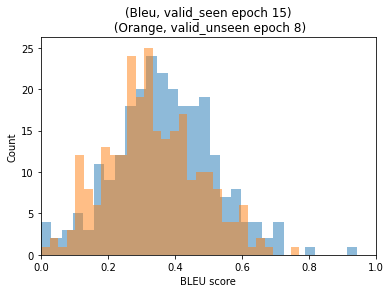

In [27]:
plt.hist(all_valid_seen_bleu_scores, density=False, bins=30, alpha=0.5)
plt.hist(all_valid_unseen_bleu_scores, density=False, bins=30, alpha=0.5)
plt.xlim(0.0, 1.0)
plt.title('(Bleu, valid_seen epoch {})\n (Orange, valid_unseen epoch {})'.format(valid_seen_best_epoch, valid_unseen_best_epoch))
plt.ylabel('Count')
plt.xlabel('BLEU score');

In [16]:
# BEST valid_seen
examine_sampled_tasks(sampled_task_ids=ranked_valid_seen_ids_best_10, epoch_list=valid_seen_epoch_list, split='valid_seen')

SPLIT: valid_seen



TASK : trial_T20190908_232929_254246_0
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'LookUp_15', 'LookUp_15', 'LookUp_15', 'ToggleObjectOn']
---------------------------
Gold instruction descriptions:

Annotation 0
Examine a remote control by the light of a floor lamp.
['Turn left towards the remote control on the coffee table.', 'Pick up the remote control from the coffee table.', 'Turn right and walk to the tall lamp in the corner.', 'Turn on the lamp.'] 

Annotation 1
Exami


Annotation 1
Pick up a bowl and turn a lamp on.
['Turn to the left and face the desk.', 'Pick the brown bowl up from the desk.', 'Move to the right and face the lamp on the right side of the desk.', 'Turn the lamp on.'] 

Annotation 2
Pick up a brown bowl to look at under a lit lamp.
['Make a left to cross the room towards the desk.', 'Pick up the brown bowl from the desk.', 'Walk to the right part of the desk, next to the plant.', 'Turn on the lamp on the desk.'] 

---------------------------

Epoch 0 Prediction Output:
BLEU score: 0.41015121175181574
turn left and walk to the counter . pick up the knife on the counter . turn around and walk to the counter . turn left and walk to the end of the room . turn left and walk to the lamp on the desk . turn on the lamp .

Epoch 1 Prediction Output:
BLEU score: 0.5974025428588418
turn left and walk to the desk . pick up the book on the desk . turn right and walk to the desk . turn on the lamp on the desk .

Epoch 3 Prediction Output:
BLEU sc

In [17]:
# BEST valid_unseen
examine_sampled_tasks(sampled_task_ids=ranked_valid_unseen_ids_best_10, epoch_list=valid_unseen_epoch_list, split='valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190908_214946_567644_0
Number of subgoals : 7
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'CleanObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'PickupObject', 'RotateLeft_90', 'RotateLeft_90', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'RotateRight_90', 'PutObject', 'ToggleObjectOn', 'ToggleObjectOff', 'PickupObject', 'RotateRight_90', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'RotateLeft_90', 'OpenObject', 'PutObject', 'CloseObject']
---------------------------
Gold instruction descriptions:

Annotation 0
Put a clean bar of soap in a cabinet.
['Walk up to the right side of the sink counter.', 'Pick up the bar of soap off of the toilet tank to your right.', 'Walk over to the ri


Epoch 1 Prediction Output:
BLEU score: 0.47339134359993695
turn left and go to the counter to the right of the sink . pick up the knife from the counter . turn left and go to the sink . put the knife in the sink . turn left and go to the counter to the right of the sink . pick up the knife on the counter . turn left and go to the sink . slice the potato in the sink . turn left and go to the microwave . heat the potato slice in the microwave . turn left and go to the sink . put the potato slice in the sink .

Epoch 3 Prediction Output:
BLEU score: 0.3819137818398584
turn left and go to the counter with the toaster on it . pick up the knife on the counter . turn left and go to the sink . slice the potato in the sink . turn around and go to the sink . put the knife in the sink . turn left , go forward , turn left at the counter to the left of the sink . pick up a slice of bread from the counter . turn right , go forward , turn left , go forward , turn left to the stove . put the bread in

In [18]:
# WORST valid_seen
examine_sampled_tasks(sampled_task_ids=ranked_valid_seen_ids_worst_10, epoch_list=valid_seen_epoch_list, split='valid_seen')

SPLIT: valid_seen



TASK : trial_T20190907_164104_229696_0
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateRight_90', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'LookDown_15', 'PutObject']
---------------------------
Gold instruction descriptions:

Annotation 0
move a box from the couch to the dresser
['turn right, turn right, walk towards the door, turn left to face the couch', 'pick up the box that is on th

In [19]:
# WORST valid_unseen
examine_sampled_tasks(sampled_task_ids=ranked_valid_unseen_ids_worst_10, epoch_list=valid_unseen_epoch_list, split='valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190907_133953_562557_0
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateRight_90', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'LookUp_15', 'LookUp_15', 'PickupObject', 'LookDown_15', 'LookDown_15', 'RotateRight_90', 'MoveAhead_25', 'RotateLeft_90', 'LookDown_15', 'ToggleObjectOn']
---------------------------
Gold instruction descriptions:

Annotation 0
Examine the bowl by the light on the desk. 
['Turn around, go forward, turn left, go forward, turn left, face the desk. ', 'Pick up the bowl from the shelf. ', 'Bring the bowl to the lamp on the desk. ', 'Turn on the lamp on